In [204]:
using GLM
using DataFrames
using Random
using Parquet
import YAML
using Plots
using CSV
import OrderedCollections: OrderedDict
using StatsBase
import Term: tprintln
import HypothesisTests: EqualVarianceTTest, pvalue
using MultipleTesting

using MyterialColors
import MyterialColors: blue, red

# import Pkg
# Pkg.add(url="https://github.com/JuliaPlots/VennEuler.jl.git")
using VennEuler



colors = OrderedDict(   
    "complete" => "black",
    "with_speed_class" => red,
    "with_omega_class" => indigo,
    "with_v" => orange,
    "with_v_squared" => orange_dark,
    "with_dv_300ms" => pink_dark,
    "with_omega" => blue,
    "with_omega_squared" => blue_dark,
    "with_domega_300ms" => purple_dark,
    "with_apex_distance" => green_dark,
    
)


include(raw"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\glm\glm_utils.jl");

REGION = "CUN/PPN"

metadata = filter(kv -> kv.second["region"] == REGION, metadata)

╭──── Dict {Any, Any}  ───────────────────────────────────────────────────────╮
│                                                                             │
│   {String} │ FC_210906_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210831_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210830_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_210831_BAA1110281_hairpi... => Dict("unit_data" ... ...     │
│   {String} │ FC_220119_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_220119_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_220117_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_211022_BAA110516_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_220119_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│   {String} │ FC_220120_BAA110517_hairpin... => Dict("unit_data" ... ...     │
│      ⋮     │               ⋮          

## Load GLM results
Load metadata of which cells were ran and their correlations

In [205]:
fitted = filter(kv -> kv.second["glm_fitted"], metadata)
@info "Fitted $(length(fitted))/$(length(metadata)) units"

formulas = generate_formulas()

for (k,v) in fitted
    # get the pearson correlations
    v["correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "correlations.csv")
    ))

    # get the correlations of the shuffled data
    v["shuffled_correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "shuffled_correlations.csv")
    ))

    # get a `FittedModel`
    try
        v["model"] = load_fitted(v, "complete", formulas)
    catch
        v["model"] = nothing
    end
end

nomodel = filter(kv -> isnothing(kv.second["model"]), fitted) |> keys |> collect
length(nomodel) > 0 && @info "No model fitted for $(length(nomodel)) units - revise metadata";

@Info (Main):  Fitted 126/126 units 
  ╰──────────────────────────────────────────────── 
                      Mon, 18 Jul 2022 10:30:23 


## Identify tuned
Look for units whose pearson correlation in the full mode is above the 99th CI of the shuffled correlations

In [206]:
tuning_percintle_th = 95

95

In [207]:
to_ignore = []
for (k, unit) in fitted
    cbest = mean(unit["correlations"][:, "complete"])
    cshuff = mean.(eachcol(unit["shuffled_correlations"]))
    threshold = 0.0
    try
        threshold = percentile(cshuff, tuning_percintle_th) 
    catch
        @info "nans in correlation"
        push!(to_ignore, k)
        continue
    end

    unit["correlation_threshold"]  = threshold
    unit["tuned"] = cbest > threshold
end

@info "something went wrong for $(length(to_ignore)) units" 

tuned = filter(kv -> kv.first ∉ to_ignore, fitted)
tuned = filter(kv -> kv.second["tuned"], tuned)
tuned = OrderedDict(sort(collect(tuned), by = kv->kv.second["best_corr"]))
@info "Tuned $(length(tuned))/$(length(fitted)) $(length(tuned) / length(fitted) * 100) units"

@Info (Main):  something went wrong for 0 units 
  ╰──────────────────────────────────────────────── 
                      Mon, 18 Jul 2022 10:30:24 
@Info (Main):  Tuned 33/126 26.190476190476193 units 
  ╰──────────────────────────────────────────────── 
                      Mon, 18 Jul 2022 10:30:24 


### plot fraction of tuned units

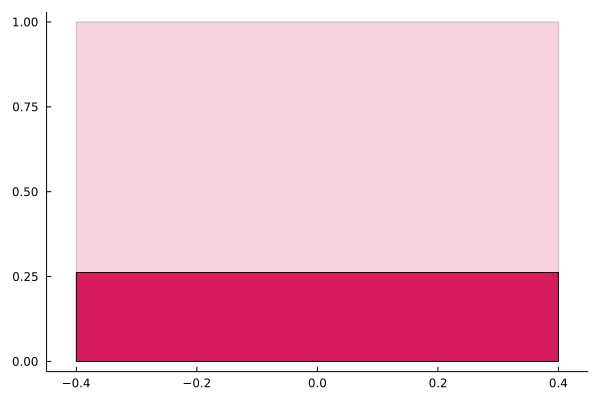

In [208]:
import MyterialColors: teal_dark


col = REGION == "MOs" ? teal_dark : pink_dark

fig = bar([0], [1], color=col, label=nothing, alpha=.2, grid=false)
bar!([0], [length(tuned) / length(fitted)], color=col, label=nothing, alpha=1)

REGION = REGION == "CUN/PPN" ? "CUN_PPN" : REGION
savefig("D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\glm_frac_tuned_$(REGION).svg")
fig

plot a single tuned unit

In [209]:
unit = collect(values(tuned))[end-42]
unit_data = load_data(unit)



x = load_data(unit["model"])
ŷ = predict(unit["model"], x) * 1000
y = x.p_spike * 1000

t0 = 5_001
t1 = t0 + 60_000

time = collect(0:(t1-t0)) / 1000  # time in seconds

fig = plot(ylabel="firing rate (Hz)", xlabel="time", size=(1000, 600), grid=false,
left_margin = 5Plots.mm, right_margin = 15Plots.mm,
)

plot!(time,  y[t0:t1], fillrange =0, fillcolor=:black, fillalpha=.2, color="black", lebel="data", alpha=.5, lw=0, label="data")
plot!(time,  ŷ[t0:t1], fillrange =0, fillcolor=:red, fillalpha=.15, lw=1, alpha=.5, label="full model", color="red")


for variable in ("speed_class", "omega_class", "dv_300ms", "domega_300ms", "apex_distance")
    mod = load_fitted(unit, "with_$variable")
    ŷ_nov = predict(mod, unit_data) * 1000
    plot!(time,  ŷ_nov[t0:t1], lw=2.5, alpha=.75, label="$variable only", color=colors["with_$variable"])
end




# savefig("D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\glm_example_weird.svg")

fig


BoundsError: BoundsError: attempt to access 33-element Vector{Any} at index [-9]

## Variables tuning

Start by plotting for a unit the pearson correlation of each model and compare it to the full model.

D:\GLM\FC_220119_BAA110517_hairpin_unit_344

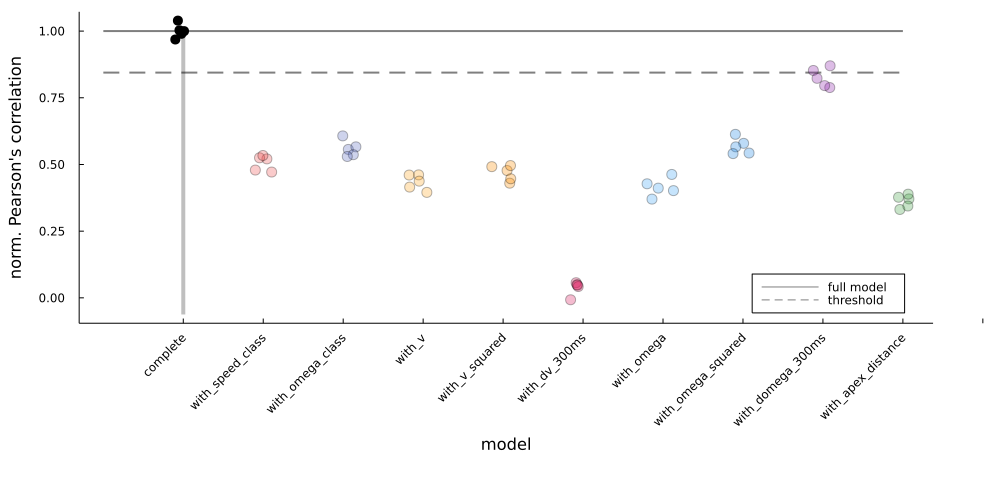

In [210]:
unit = collect(values(tuned))[end]
print(unit["folder"])
mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))
# threshold = .2

complete_model_corr = mean_corr["complete"]
corrs = OrderedDict(k => v./complete_model_corr for (k,v) in zip(names(unit["correlations"]), values(eachcol(unit["correlations"]))))

# get pvalues betweeen all models correlations and complete
filtered_keys = filter!(k -> k != "complete", collect(keys(corrs)))
pvals = map(
    k -> pvalue(
        EqualVarianceTTest(
            values(corrs[k]),
            values(corrs["complete"])
        )
    ),
    filtered_keys
)
pvals = Dict( k => p for (k, p) in zip(filtered_keys, adjust(pvals, Bonferroni())))


# cshuff = mean.(eachcol(unit["shuffled_correlations"]))
cshuff = map(
    i -> mean(unit["shuffled_correlations"][:, i]), 1:100
)
threshold = percentile(cshuff, tuning_percintle_th) / complete_model_corr

# plot
plot()
plot!([0, length(mean_corr)], [1, 1], color="black", alpha=.5, lw=2, label="full model")
plot!([0, length(mean_corr)], [threshold, threshold], color="black", linestyle=:dash, alpha=.5, lw=2, label="threshold")

for (i, model) in enumerate(keys(colors))
    corr = mean_corr[model] ./ complete_model_corr
    istuned = corr >= threshold

    scatter!(ones(5)*i .+ 0.1randn(5), corrs[model], color=colors[model], ms=6, alpha= istuned ? 1 : .3, label=nothing)
    # scatter!([i], [corr], label=nothing)
    istuned && plot!(
        [i, i],
        [min(values(mean_corr)...) / complete_model_corr - .1, corr],
        color=colors[model],
        alpha=.25,
        lw=4,
        label=nothing
    )
end

plot!(   
    xticks = (
        1:length(mean_corr)+1,
        keys(colors)
    ), 
    xrotation = 45,
    ylabel = "norm. Pearson's correlation",
    xlabel = "model",
    grid=false,
    size=(1000, 500),
    left_margin = 5Plots.mm, right_margin = 15Plots.mm,
    bottom_margin = 25Plots.mm,
    legend=:bottomright
    )



Get all tuning for all units

In [211]:
variables_tuning = Dict{String, Vector{Bool}}(k => [] for k in keys(colors))

for (name, unit) in tuned
    # get mean pearson correlation of each model and threshold
    mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))   
    complete_model_corr = mean_corr["complete"]
    # corrs = OrderedDict(k => v./complete_model_corr for (k,v) in zip(names(unit["correlations"]), values(eachcol(unit["correlations"]))))

    cshuff = mean.(eachcol(unit["shuffled_correlations"]))
    threshold = percentile(cshuff, tuning_percintle_th) / complete_model_corr
    
    for model in keys(colors)
        corr = mean_corr[model] ./ complete_model_corr
        istuned = corr >= threshold
        push!(variables_tuning[model],  istuned)
    end
end

variables_tuning = DataFrame(variables_tuning);

In [212]:
ntuned_var = Dict(k=>sum(variables_tuning[:, k]) for k in keys(colors))
var_classes =  ["with_omega_class", "with_speed_class", "with_dv_300ms", "with_domega_300ms", "with_apex_distance"]
classes_names = ["angular velocity", "speed", "Δspeed", "Δω", "apex distance"]

# get percentage of units tuned to each class of variables
ntotal = length(tuned)
for (n, var) in zip(classes_names, var_classes)
    # print number of units tuned to class vs total
    ntuned = ntuned_var[var]
    tprintln("{green}$(ntuned){/green}/$(ntotal) ($(round(ntuned/ntotal * 100; digits=2))%) units tuned to {bold white}$(n){/bold white}";)
end

6/33 (18.18%) units tuned to angular velocity 
13/33 (39.39%) units tuned to speed 
1/33 (3.03%) units tuned to Δspeed 
0/33 (0.0%) units tuned to Δω 
2/33 (6.06%) units tuned to apex distance 


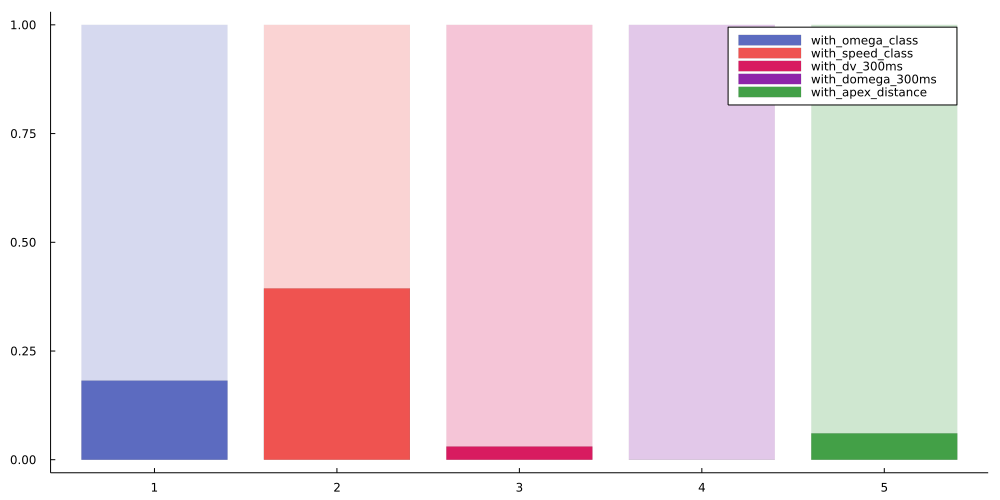

In [213]:
# plot fraction of units tuned to each class of variables as barplot

fig = plot(grid=false, size=(1000, 500))

ntotal = length(tuned)
for (i, (n, var)) in enumerate(zip(classes_names, var_classes))
    # print number of units tuned to class vs total
    ntuned = ntuned_var[var]
    f = ntuned/ntotal

    bar!([i], [1], color=colors[var], alpha=.25, lw=0, label=nothing)
    bar!([i], [f], color=colors[var],  lw=0, label=var)
end

savefig("D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\glm_frac_tuned_eachvar_$(REGION).svg")
fig




get how many units are tuned to > 1 class of variables

Get how many units are tuned to `speed`, `omega` and spatial info.

In [214]:
import OrderedCollections: OrderedDict
import Term: Table, Panel, hLine, cvstack
import Term: highlight

N = size(variables_tuning, 1)
count_perc(x) = highlight("$(x)/$(N) ($(round(x/N * 100; digits=2))%)")

tb(x) = Table(
    x;
    header_style="bold white on_black",
    box=:NONE, style="blue"
)

classes = ["with_v", "with_v_squared",  "with_dv_300ms"]
cnames = ["speed", "speed²", "Δv 300ms"]


V = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


classes = ["with_omega", "with_omega_squared", "with_domega_300ms"]
cnames = ["ang. velocity","ω²", "Δω 300ms"]

O = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


classes = ["with_apex_distance"]
cnames = ["apex distance"]

K = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb


Panel(
    cvstack(Panel(V; fit=false, width=100, title="SPEED", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(118; box=:HEAVY), "",
    Panel(O; fit=false, width=100, title="ANGULAR VELOCITY", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(118; box=:HEAVY), "",
    Panel(K; fit=false, width=100, title="POSITION", title_style="bold red", title_justify=:center, justify=:center, box=:NONE));
    fit=false, width=120, justify=:center
)

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                           SPEED                                                      │
│                                                                                                                      │
│                                        speed              speed²           Δv 300ms                                  │
│                                                                                                                      │
│                                    11/33 (33.33%)     12/33 (36.36%)     1/33 (3.03%)                                │
│                                                                                                                      │
│                                                                                                                      │
│  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Get how many units are tuned to speed/ang vel now, in the future or both

In [215]:
speed_tuned = variables_tuning[:, "with_v"] .|| variables_tuning[:, "with_v_squared"]
Δspeed_tuned = variables_tuning[:, "with_dv_300ms"]
both_tuned = speed_tuned .&& Δspeed_tuned

Dict(
    :speed=> count_perc(sum(speed_tuned)),
    :Δspeed=> count_perc(sum(Δspeed_tuned)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ────────────────────────╮
│                                                    │
│   {Symbol} │  both  =>  1/33 (3.03%)  │ {String}   │
│   {Symbol} │ Δspeed =>  1/33 (3.03%)  │ {String}   │
│   {Symbol} │ speed  => 12/33 (36.36%) │ {String}   │
│                                                    │
╰──────────────────────────────────────── 3 items ───╯


In [216]:
speed_tuned = variables_tuning[:, "with_omega"] .|| variables_tuning[:, "with_omega_squared"]
Δspeed_tuned = variables_tuning[:, "with_domega_300ms"]
both_tuned = speed_tuned .&& Δspeed_tuned

Dict(
    :ω=> count_perc(sum(speed_tuned)),
    :Δω=> count_perc(sum(Δspeed_tuned)),
    :both=> count_perc(sum(both_tuned))
)

╭──── Dict {Symbol, String}  ─────────────────────╮
│                                                 │
│   {Symbol} │ both =>  0/33 (0.0%)  │ {String}   │
│   {Symbol} │  Δω  =>  0/33 (0.0%)  │ {String}   │
│   {Symbol} │  ω   => 5/33 (15.15%) │ {String}   │
│                                                 │
╰───────────────────────────────────── 3 items ───╯


In [217]:
# apex_distance_tuning = variables_tuning[:, "with_apex_distance"] 
# any_tuned = curv_tuning .&& s_tuning .&& apex_distance_tuning

# Dict(
#     :apex_distance=> count_perc(sum(apex_distance_tuning)),
# )